In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [17]:
#Get data from api
def get_data(prd):
    stock_list = ['AAPL','MSI','SBUX']
    stock_data = pd.DataFrame()
    for sl in stock_list:
        data = yf.Ticker(sl).history(period=prd)
        data['stock'] = sl
        data = data.reset_index()
        data = data.loc[:,['Date','Close','stock']]
        stock_data = pd.concat([data,stock_data])

    stock_data=stock_data.pivot(index= 'Date',columns='stock', values='Close')
    stock_data = stock_data.reset_index()

    stock_data = stock_data[['AAPL','MSI','SBUX']]
    stock_data = stock_data.reset_index(drop=True)

    stock_data.to_csv('stock_data.csv',index=False)

#write data
get_data(prd = '5y')

In [18]:
#Get data from csv
stock_data = pd.read_csv('stock_data.csv')
stock_data = stock_data.values

,AAPL,MSI,SBUX
0,34.018082,77.403618,52.205791
1,33.973232,78.084450,52.768318
2,33.909504,79.326523,52.976994
3,33.918957,78.047630,53.022358
4,34.171509,77.762421,52.913483


In [22]:
def get_scaler(env):
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state,reward,done,info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

In [23]:
def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [40]:
class LinearModel:
    def __init__(self,input_dim,n_action):
        self.W = np.random.randn(input_dim,n_action)/ np.sqrt(input_dim)
        self.b = np.zeros(n_action)

        #momentum terms
        self.vW = 0
        self.vb = 0

        self.losses = []

    def predict(self,X):
        # X should be N *D
        assert(len(X.shape)==2)
        return X.dot(self.W)+ self.b

    def sgd(self,X,Y,learning_rate = 0.01,momentum = 0.9):
        assert(len(X.shape)==2)

        # loss values are 2-D
        num_values = np.prod(Y.shape)

        Yhat = self.predict(X)
        gW = 2 * X.T.dot(Yhat - Y) / num_values
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values

        #Update momentum
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb

        #update params
        self.W += self.vW
        self.b += self.vb

        mse = np.mean((Yhat - Y)**2)
        self.losses.append(mse)

    def load_weights(self,filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

    def save_weights(self,filepath):
        np.savez(filepath, W = self.W, b = self.b)




In [41]:
class MultiStockEnv:

    def __init__(self,data,initial_investment = 20000):

        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        #instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        #actions: [0,0,1] or [0,2,1]
        # 0 = sell, 1 = hold, 2 = buy
        self.action_list = list(map(list,itertools.product([0,1,2], repeat=self.n_stock)))

        #calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()

    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()

    def step(self, action):
        assert action in self.action_space

        #get current value before performing the action
        prev_val = self._get_val()

        #update price, go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        #perform the trade
        self._trade(action)

        #get the new value after taking the action

        cur_val = self._get_val()

        #reward is the increase in the value
        reward = cur_val - prev_val

        #done if we run out of data
        done = self.cur_step == self.n_step - 1

        #store the current value  of portfolio
        info = {'cur_val':cur_val}

        return self._get_obs(),reward,done,info

    #return the state
    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2 * self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs

    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):
        action_vec = self.action_list[action]

        #determine which stock to buy or sell
        sell_index = []
        buy_index = []
        for i,a in enumerate(action_vec):
            if a ==0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        #sell the stock we want to sell, then buy the stock we want to buy
        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0

        if buy_index:
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False



In [42]:
class DQNAgent(object):
    def __init__(self,state_size,action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95 # discount rate
        self.epsilon = 1.0 #exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size,action_size)

    def act(self,state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def  train(self,state,action,reward,next_state,done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.argmax(self.model.predict(next_state),axis = 1)

        target_full = self.model.predict(state)
        target_full[0,action] = target

        #Run one training step
        self.model.sgd(state,target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self,name):
        self.model.load_weights(name)

    def save(self,name):
        self.model.save_weights(name)





In [43]:
def play_one_episode(agent,env,is_train):
        # note: after transforming states are already 1 * D
        state = env.reset()
        state = scaler.transform([state])
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            next_state = scaler.transform([next_state])
            if is_train == 'train':
                agent.train(state,action,reward,next_state,done)
            state = next_state

        return info['cur_val']

In [51]:
if __name__ == '__main__':

    #config
    models_folder = 'linear_rl_trader_models'
    rewards_folder = 'linear_rl_trader_rewards'
    num_episodes = 2000
    batch_size = 32
    initial_investment = 20000

    mode = 'test'

    maybe_make_dir(models_folder)
    maybe_make_dir(rewards_folder)

    data = stock_data
    n_timesteps, n_stocks = data.shape

    n_train = n_timesteps // 2

    train_data = data[:n_train]
    test_data = data[n_train:]

    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)

    #store the final value of the portfolio (end of the episode)
    portfolio_value = []

    if mode == 'test':
        # load the pervious models
        with open(f'{models_folder}/scaler.pkl','rb') as f:
            scaler = pickle.load(f)

        # remake the env with test data
        env = MultiStockEnv(test_data, initial_investment)

        # make sure epsilon is not 1!
        # no need to run multiple episodes if epsilon = 0, it's deterministic.
        agent.epsilon = 0.01

        #load trained weights
        agent.load(f'{models_folder}/linear.npz')

    # play the game num_episodes times
    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent,env,mode)
        dt = datetime.now()- t0
        print(f"episode: {e + 1}/{num_episodes}, episodes end value: {val:.2f}, duration:{dt}")
        portfolio_value.append(val)

    #save the weights when we are done
    if mode == 'train':
        #save the DQN
        agent.save(f'{models_folder}/linear.npz')

        #save the scaler
        with open(f'{models_folder}/scaler.pkl','wb') as f:
            pickle.dump(scaler,f)

        #plot losses
        plt.plot(agent.model.losses)
        plt.show()

    # save portfolio value for each episode
    np.save(f'{rewards_folder}/{mode}.npy', portfolio_value)

episode: 1/2000, episodes end value: 33267.24, duration:0:00:00.058030
episode: 2/2000, episodes end value: 33014.09, duration:0:00:00.053191
episode: 3/2000, episodes end value: 41541.06, duration:0:00:00.056999
episode: 4/2000, episodes end value: 48270.93, duration:0:00:00.052999
episode: 5/2000, episodes end value: 48473.11, duration:0:00:00.052965
episode: 6/2000, episodes end value: 33625.67, duration:0:00:00.060008
episode: 7/2000, episodes end value: 34123.55, duration:0:00:00.060992
episode: 8/2000, episodes end value: 38428.99, duration:0:00:00.071510
episode: 9/2000, episodes end value: 42215.57, duration:0:00:00.098008
episode: 10/2000, episodes end value: 42154.64, duration:0:00:00.121992
episode: 11/2000, episodes end value: 48761.15, duration:0:00:00.078704
episode: 12/2000, episodes end value: 47745.29, duration:0:00:00.099001
episode: 13/2000, episodes end value: 43096.41, duration:0:00:00.208066
episode: 14/2000, episodes end value: 45616.21, duration:0:00:00.138325
e

average reward: 40561.33, min:20887.55, max: 69939.22


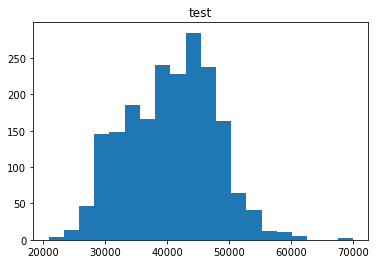

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import argparse

a = np.load(f'linear_rl_trader_rewards/{mode}.npy')

print(f"average reward: {a.mean():.2f}, min:{a.min():.2f}, max: {a.max():.2f}")

plt.hist(a, bins = 20)
plt.title(mode)
plt.show()